## Visualize boxes before and after yolo annotation
A notebook to visualize images with bounding boxes before and after yolo annotation, width the resized images. 

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from IPython.display import display
from matplotlib.patches import Rectangle


import torch
SEED = 117
torch.manual_seed(SEED)

#### Prepare X and y for augmented images

In [2]:
def Dataframe_data(root_path):
    
    # Annotationsdata
    data = pd.read_csv(root_path + 'AnnotationsCollated.csv', delimiter=';', header=None)

    #Delete questionable
    image_type = data.iloc[:,5]

    index_list = []
    for index, row in image_type.iteritems():
        if row == 'Questionable':
            index_list.append(index)
    data = data.drop(index=index_list)
    display(data)

    # Name Dataframe
    names = data.iloc[:,3]
    number = data.iloc[:,4]

    names_concat = pd.concat([names, number], axis=1)
    names_concat.columns = ['Name', 'Number']
    names_concat['Name'] = names_concat['Name'].astype(str) + '_' + names_concat['Number'].astype(str)
    new_name = names_concat.iloc[:,0].values

    # Label Dataframe
    number_of_boxes = data.iloc[:,6]
    box = data.iloc[:,7]
    label_t_l = data.iloc[:,8]
    label_v_a = data.iloc[:,5]
    label_concat = pd.concat([number_of_boxes, box, label_t_l, label_v_a], axis=1)

    return new_name, label_concat

root_path = '/Volumes/T7/ProcessedRequestData/ProcessedData/'
X_b, y_b = Dataframe_data(root_path)


0      1                2  \
0        Patient1  Case1  MeasurementSet1   
1        Patient1  Case1  MeasurementSet2   
2        Patient1  Case1  MeasurementSet3   
3        Patient1  Case1  MeasurementSet4   
4        Patient1  Case1  MeasurementSet5   
...           ...    ...              ...   
14741  Patient184  Case1  MeasurementSet1   
14742  Patient184  Case1  MeasurementSet2   
14743  Patient184  Case1  MeasurementSet3   
14744  Patient184  Case1  MeasurementSet4   
14746  Patient184  Case1  MeasurementSet6   

                                          3   4        5  6  \
0      eda1fb4b-0902-4cd1-837c-bddd221fddb6  63  Unknown  0   
1      ce699728-7891-4af5-bb0c-ce4067f65a89  16    Aorta  1   
2      8b8aa37a-3905-4753-bb0b-f7b7661bc40a  37    Aorta  1   
3      f7f27ea3-b1e5-49e0-ad52-29bb2c4c58f2  37  Unknown  0   
4      3fc88f9a-11de-4de8-813c-de2095d41eb7  37  Unknown  0   
...                                     ...  ..      ... ..   
14741  73c6d87e-a203-4ed7-9342-8b0ff88e2825  31  Unknown  0   
14742  909bd4a8-f27b-4af2-ae3c-5288db32f1f3  58  Unknown  0   
14743  60f1babb-72a5-4d62-b966-783caeb6c07d  77  Unknown  0   
14744  959c8ab2-7426-492a-be16-b02d61f2b0ed  37  Unknown  0   
14746  3b299dd3-6c92-4dda-aebf-f3787bd0fedf  37    Aorta  1   

                             7      8  
0                           []     []  
1      [[(2, 26), (232, 527)]]  ['T']  
2      [[(5, 30), (229, 520)]]  ['T']  
3                           []     []  
4                           []     []  
...                        ...    ...  
14741                       []     []  
14742                       []     []  
14743                       []     []  
14744                       []     []  
14746  [[(2, 24), (231, 414)]]  ['T']  

[13745 rows x 9 columns]

In [3]:
def box_labels(label):
        
    # Replace the string with right characters and reshape. 
    box = label[1].replace("(", "").replace("[", "").replace(")", "").replace("]", "").replace(" ", "").split(",")
    box_array = np.array([int(character) for character in box]).reshape(label[0], 4)
            
    return box_array

In [4]:
#Gaussian noise
def add_noise(inputs,noise_factor=0.3):
     noisy = inputs+torch.randn_like(inputs) * noise_factor
     noisy = torch.clip(noisy,0.,1.)
     return noisy

In [5]:
def data_augmentation(X_b,y_b, image_path, crop_pixel):
    #Dictionary with image name and path to image
    img_dict = {}
    img_object = []
    
    for image, label in zip(X_b, y_b.values):
        #If no object in image, do not augmentate the image
        if label[0] == 0:
            img_dict[image] = f"{image_path}/{image}.png"
            continue
        if label[3] == "Unknown" or label[3] == "Questionable" or label[3] == "Blank":
            img_dict[image] = f"{image_path}/{image}.png"
            continue
        
        img_object.append(image)
        img_object.append(f"{image}_aug")

        #Add image to dict
        img_dict[image] = f"{image_path}/{image}.png"

        #Bounding boxes of cropped images
        new_box_array = []
        box_array = box_labels(label)
        for box_element in box_array:
            box_element[0] = box_element[0] - crop_pixel/2 #x1
            box_element[2] = box_element[2] - crop_pixel/2 #x2
            box_element[1] = box_element[1] - crop_pixel/2 #y1
            box_element[3] = box_element[3] - crop_pixel/2 #y2 

            box_element = [box_element[0], box_element[1], box_element[2], box_element[3]]
            new_box_array.append(box_element)

        #Save the augmented image to the same path as the original image with name_aug at the end, add do dictionary
        img_dict[f"{image}_aug"] = f"{image_path}/{image}_aug.png"
        

        #Make a copy of the label accordingly - save in y
        y_b.reset_index(inplace=True, drop=True)
        y_b.loc[len(y_b.index)] = [label[0], str(new_box_array), label[2], label[3]]
        
        
        #Update X and y 
        X_b = np.append(X_b, f'{image}_aug')
        
    return X_b,y_b, img_dict, img_object

image_path = "/Volumes/T7/Master/Data_augment/PNGImages"
crop_pixel = 20
X, y, img_dict, img_object  = data_augmentation(X_b,y_b, image_path, crop_pixel)

In [6]:
def split_data(X,y):

    # Splitting into training data and test/val data
    seed = 123
    X_train, X_val_test, y_train, y_val_test = train_test_split(X,y,test_size=0.3, shuffle=True, random_state=seed)

    # Splitting the test data into validation and test data
    seed = 665
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, shuffle=True, random_state=seed)

    print('Size of the training dataset: ', len(X_train))
    print('Size of the validation dataset: ', len(X_val))
    print('Size of the test dataset: ', len(X_test))

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X,y)

Size of the training dataset:  14385
Size of the validation dataset:  3082
Size of the test dataset:  3083


#### Pick out fifty images to visualize on normal annotation

In [7]:
def box_labels(label):
        
    # Replace the string with right characters and reshape. 
    box = label[1].replace("(", "").replace("[", "").replace(")", "").replace("]", "").replace(" ", "").split(",")
    box_array = np.array([int(character) for character in box]).reshape(label[0], 4)
            
    return box_array

In [8]:
def boundingboxes(box_array, width):
    for box_element in box_array:

        #If box_width is out of bound with image width
        x1 = box_element[0]
        y1 = box_element[1]
        x2 = box_element[2]
        y2 = box_element[3]

        if box_element[0] < 0:
            box_element[0] = 0
        if box_element[1] < 0:
            box_element[1] = 0
        if box_element[2] < 0:
            box_element[2] = 0
        if box_element[3] < 0:
            box_element[3] = 0
        
        if box_element[0] > width:
            box_element[0] = width
        if box_element[2] > width:
            box_element[2] = width

        if box_element[2] < box_element[0]:
            x1 = box_element[2]
            x2 = box_element[0]
        if box_element[3] < box_element[1]:
            y1 = box_element[3]
            y2 = box_element[1]
    #print(f"This is x1, y1, x2, y2: {x1, y1, x2, y2}")
    return x1, y1, x2, y2

def find_border(x1, y1, x2, y2):   
        #(x1, y1) = top left corner, (x2, y2) = bottom right corner
        box_height = y2 - y1
        box_width = x2 - x1
        border = Rectangle((x1, y1), box_width, box_height, linewidth=1, edgecolor ='red', facecolor = 'none', fill=False) 
        return border

#### Transform the annotations to yolo labels, and visualize them again

In [9]:
def boundingboxes_yolo(box_array, height, width):
    for box_element in box_array:

        #If box_width is out of bound with image width
        box_element_width = box_element[2] 
        if box_element[2] > width:
            box_element_width = width
            
        if box_element[2] < 0:
            box_element_width = 0
        if box_element[0] < 0:
            box_element[0] = 0

        x_center = (((box_element_width - box_element[0])/2) + box_element[0])/width
        y_center = (((box_element[3] - box_element[1])/2) + box_element[1])/height
        box_width = (box_element_width - box_element[0])/width
        box_height = (box_element[3] - box_element[1])/height

        if box_element[0] > box_element_width:
            x_center = (((box_element[0] - box_element[2])/2) + box_element_width)/width
            box_width = (box_element[0] - box_element_width)/width

        if box_element[1] > box_element[3]:
            y_center = (((box_element[1] - box_element[3])/2) + box_element[3])/height
            box_height = (box_element[1] - box_element[3])/height
        
        if box_width > 1:
            box_width = 1
        if box_height >1:
            box_height = 1

    #print(f"This is x_center, y_center, box_width, box_height: {x_center, y_center, box_width, box_height}")
    return x_center, y_center, box_width, box_height

def find_border_yolo(x_center, y_center, box_width, box_height, height, width):    
        xmin = (x_center * width) - ((box_width*width)/2)
        ymin = (y_center * height) - ((box_height*height)/2)
        border = Rectangle((xmin, ymin), (box_width * width), (box_height * height), linewidth=1, edgecolor ='red', facecolor = 'none', fill=False) 
        return border

#### Visualize the images side by side?

In [10]:
def plot_bb_ss(image, resized_image, title1, title2, border, yolo_border, resized_border):
    #Plot the three images side by side
    row = 1
    col=3

    plt.figure()
    _, axs = plt.subplots(row, col)

    axs[0].imshow(image)
    axs[1].imshow(image)
    axs[2].imshow(resized_image)

    axs[0].set_title(f"{title1}")
    axs[1].set_title(f"{title2}")
    axs[2].set_title(f"Resized Image")

    axs[0].add_patch(border)
    axs[1].add_patch(yolo_border)
    axs[2].add_patch(resized_border)
    plt.show()
    

In [11]:
def plot_one(image, border):
    #If only plotting one image
    
    plt.figure()
    _, axs = plt.subplots(1,1)
    axs.imshow(image)
    axs.set_title("Annotated image")
    axs.add_patch(border)
    plt.show()

In [12]:
def resize_image(img, height, width, x1, y1, x2, y2):
    
    if height > width: 
        newsize = (width, 640)
        new_img = img.resize(newsize)

        #Add border
        background = Image.new('RGBA', (640, 640), color="gray")
        offset = (int((640-width)/2), 0)
        background.paste(new_img, offset)

        #Find x1, y1, x2, y2 for new image.
        if height > 640:
            #The height have been reduced
            percentage = 1 - (height - 640)/height
            y1_after = y1 * percentage
            y2_after = y2 * percentage
        else: 
            #The height have been increased
            percentage = 1 + (640 - height)/height
            y1_after = y1 * percentage
            y2_after = y2 * percentage
        
        gray = (640 - width)/2
        x1_after = x1 + gray
        x2_after = x2 + gray

    else:
        newsize = (640, height)
        new_img = img.resize(newsize)
        
        #Add border
        background = Image.new('RGBA', (640, 640), color="gray")
        offset = (0, int((640-height)/2))
        background.paste(new_img, offset)

        #Find x1, y1, x2, y2 for new image.
        if width > 640:
            #The width have been reduced
            percentage = 1 - (width - 640)/width
            x1_after = x1 * percentage
            x2_after = x2 * percentage
        else: 
            #The width have been increased
            percentage = 1 + (640 - width)/width
            x1_after = x1 * percentage
            x2_after = x2 * percentage
        
        gray = (640 - height)/2
        y1_after = y1 + gray
        y2_after = y2 + gray

    return background, x1_after, y1_after, x2_after, y2_after

0dc13655-c877-4d83-8b65-22f434b51ff2_32


<Figure size 640x480 with 0 Axes>

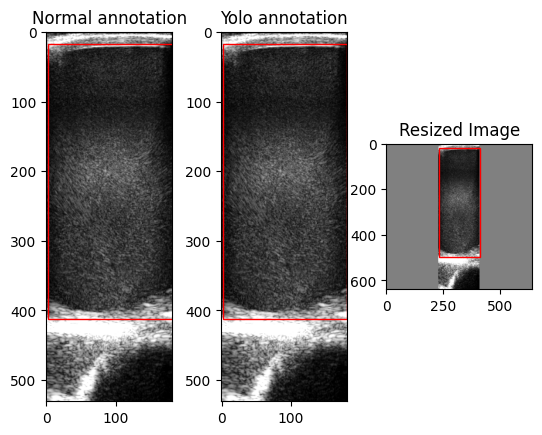

1844d958-3d01-4398-a4e7-038959e09a93_37


<Figure size 640x480 with 0 Axes>

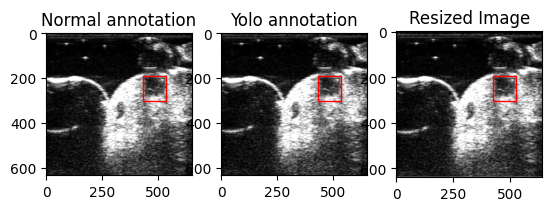

1c65f939-6003-4020-9f92-3f43e89a6307_21


<Figure size 640x480 with 0 Axes>

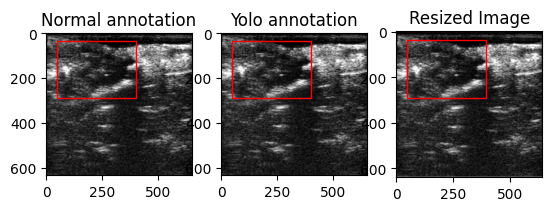

1e4f845a-f80a-4b38-b9e2-8513943418de_77


<Figure size 640x480 with 0 Axes>

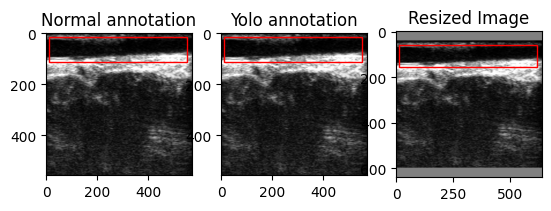

2b0cebd5-013a-491a-99b0-d16c92fdf579_37


<Figure size 640x480 with 0 Axes>

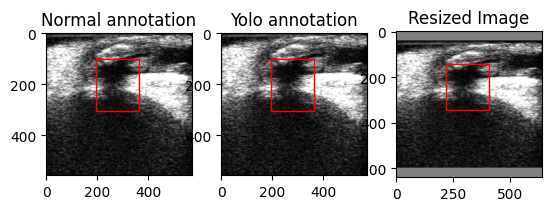

2e55e6b9-d3a8-4898-a6f6-dc6bbb287127_52_aug


<Figure size 640x480 with 0 Axes>

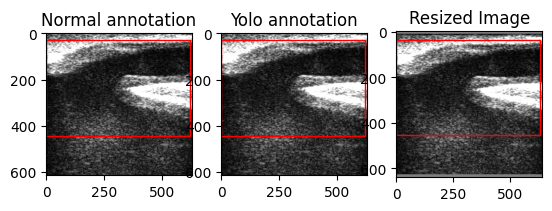

2eac2906-fc31-41fc-8244-ef4cf123743e_52


<Figure size 640x480 with 0 Axes>

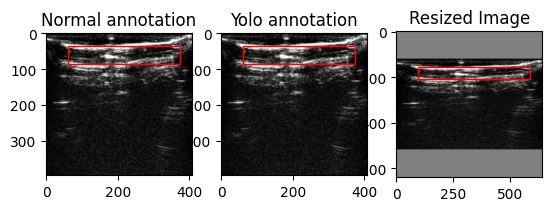

310bc109-7a25-4c0f-8287-d2b1a3028c19_58
Rectangle(xy=(125, 8), width=57, height=50, angle=0)
Rectangle(xy=(323, 9.17563), width=57, height=57.3477, angle=0)


<Figure size 640x480 with 0 Axes>

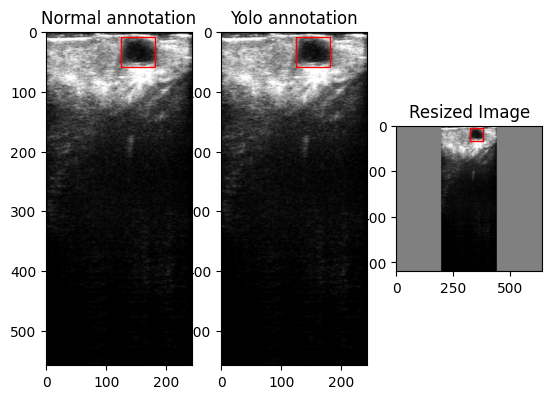

319f83c1-78ef-4f99-9e72-5c87ed6cfaac_37


<Figure size 640x480 with 0 Axes>

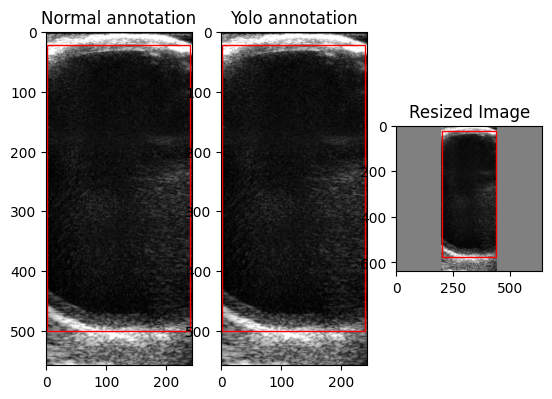

3dbb3c95-caa5-4b44-a57d-4eee4c0e675f_14


<Figure size 640x480 with 0 Axes>

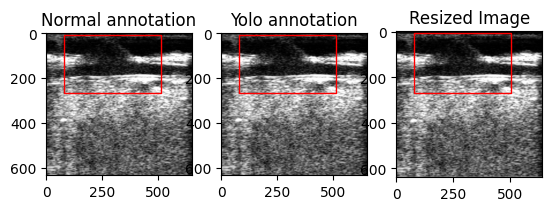

3f16fc72-f4bd-4871-b5b4-5021fa2a83c9_52


<Figure size 640x480 with 0 Axes>

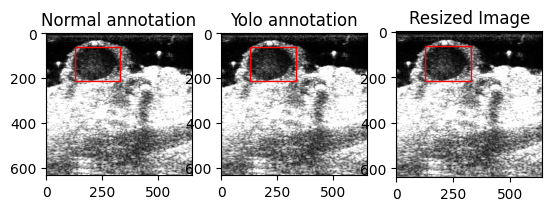

412e6794-9601-4984-bb7d-9a9dcccf5626_64


<Figure size 640x480 with 0 Axes>

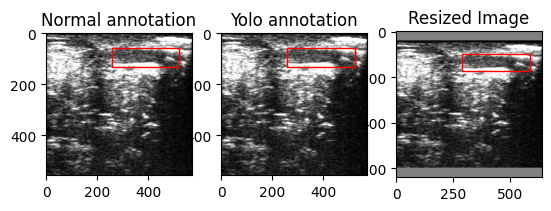

46f7394b-f9c3-4095-98f4-c3aa3ae1c48f_52


<Figure size 640x480 with 0 Axes>

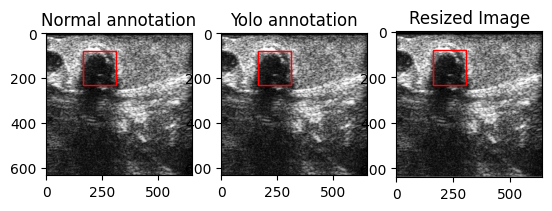

47dfea58-138a-4e38-a6c4-edf4e041b89f_47


<Figure size 640x480 with 0 Axes>

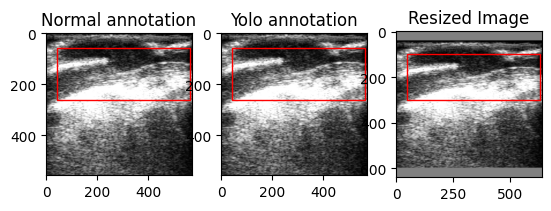

4ae9f795-a401-4542-b956-98ff5e532429_52_aug


<Figure size 640x480 with 0 Axes>

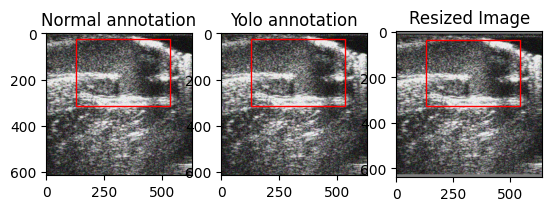

4f3c4299-c7f2-4b50-a3c4-004d54e3f051_59


<Figure size 640x480 with 0 Axes>

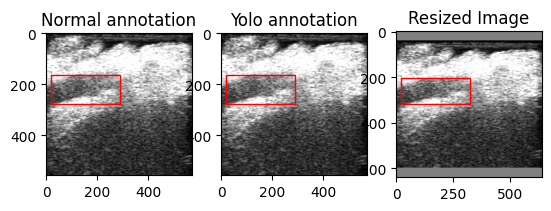

5003c0c2-52bc-491c-a673-09853906a82f_21_aug


<Figure size 640x480 with 0 Axes>

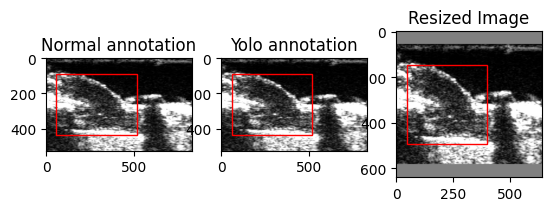

5532f715-88c8-4b5a-af75-c8a2d6e2565f_52_aug


<Figure size 640x480 with 0 Axes>

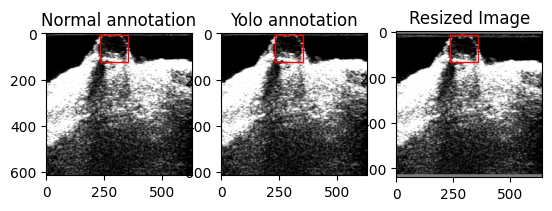

564f75b5-1f04-4cf4-9cc1-df1687084088_37


<Figure size 640x480 with 0 Axes>

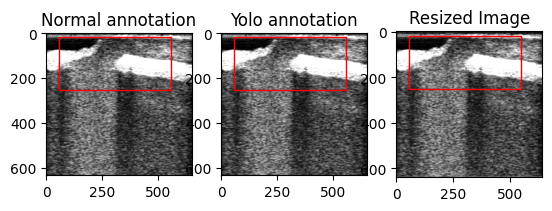

59f8d4d8-4aa6-44bf-ad84-a5fc998a9b4c_14


<Figure size 640x480 with 0 Axes>

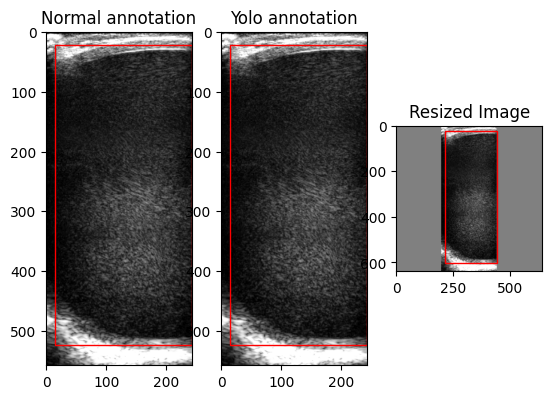

612f6b10-f1f5-4cd9-b547-4a8b6651f513_52_aug


<Figure size 640x480 with 0 Axes>

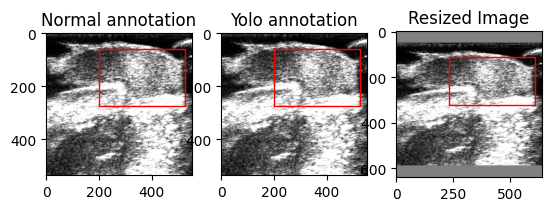

67b22919-db5e-4755-9a6d-49812eaed880_37


<Figure size 640x480 with 0 Axes>

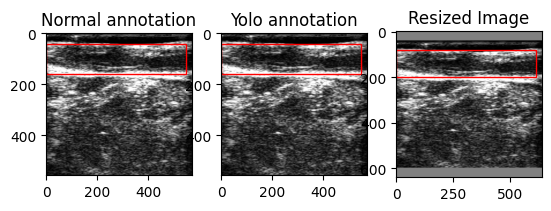

68e58c80-ee44-4f78-923a-806d5a603439_52


<Figure size 640x480 with 0 Axes>

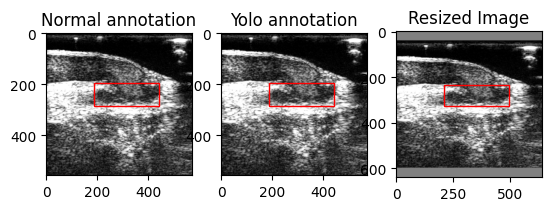

6c59e343-2b25-4d8c-acf0-bc6700008ccf_37_aug


<Figure size 640x480 with 0 Axes>

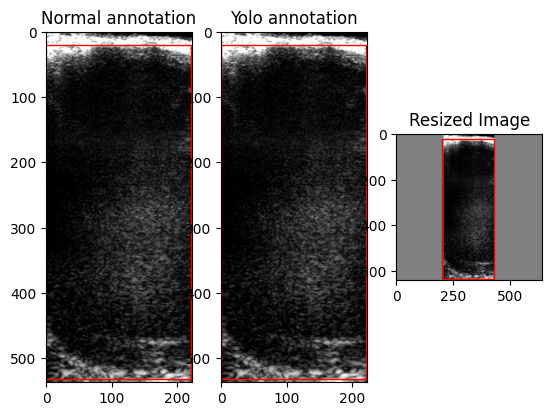

6d487317-4116-46c4-8fb7-30dd824d8c7c_37


<Figure size 640x480 with 0 Axes>

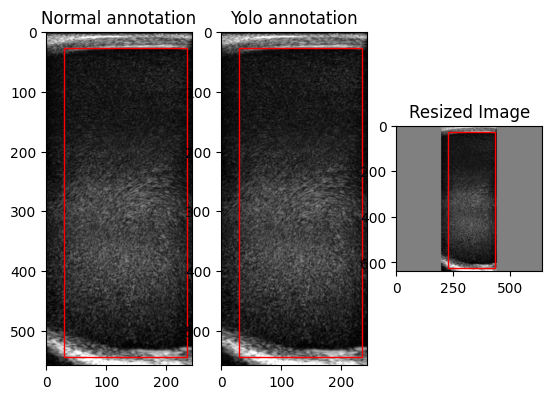

8ca21005-3751-472e-9689-4be6313a84ed_58_aug


<Figure size 640x480 with 0 Axes>

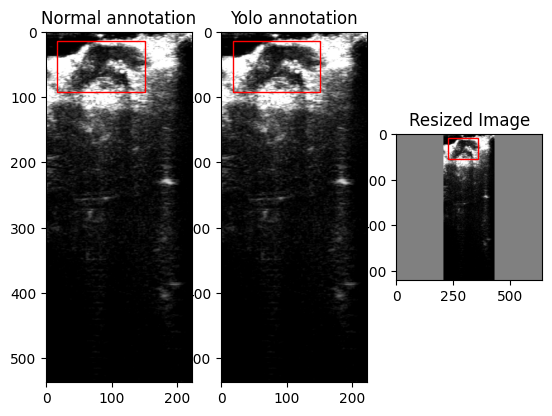

8d476078-7835-4a71-9c53-4addd4ac0b10_17_aug


<Figure size 640x480 with 0 Axes>

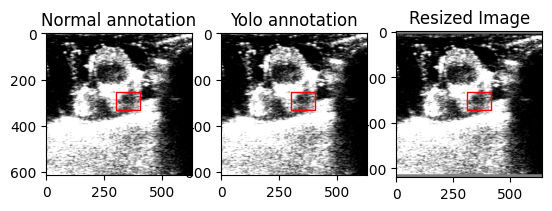

92531191-4449-4135-8575-d218e706e3e6_39


<Figure size 640x480 with 0 Axes>

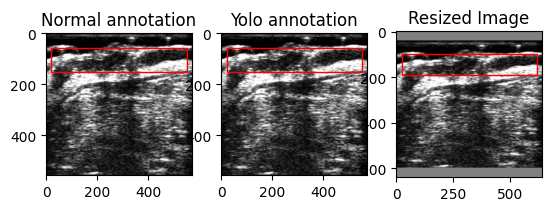

95927a87-c793-44fb-8f88-f82aac0c7b37_35


<Figure size 640x480 with 0 Axes>

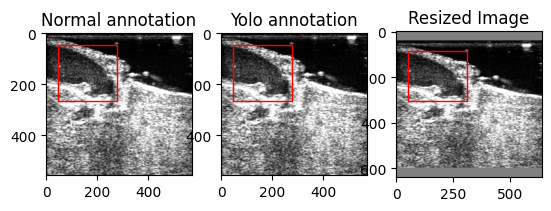

979353b4-e9de-49c1-9a3b-36fcc540b4bb_52_aug


<Figure size 640x480 with 0 Axes>

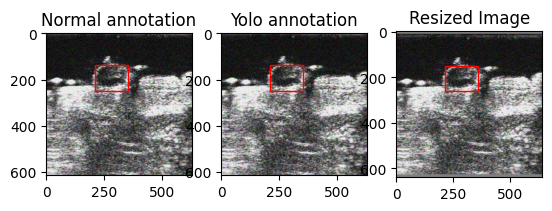

9b157da3-83ea-4576-9b8f-a8fd725211c4_94_aug


<Figure size 640x480 with 0 Axes>

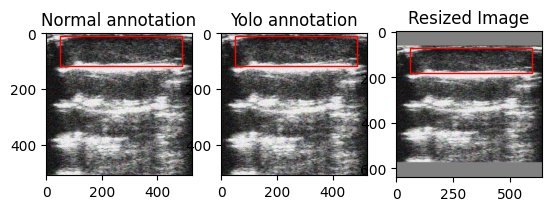

aadf1c5e-be43-49f6-bf77-a9199276d69c_52_aug


<Figure size 640x480 with 0 Axes>

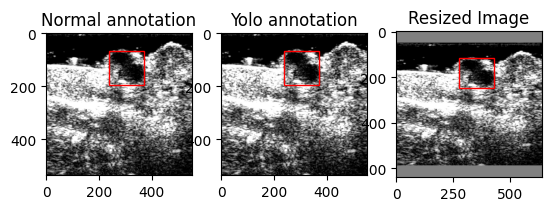

abe8da79-0d41-4e94-bafd-9c562480d20f_37_aug


<Figure size 640x480 with 0 Axes>

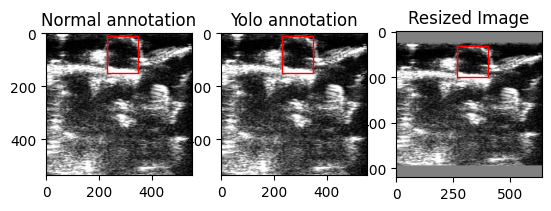

aee3b699-6c35-4e28-a8b6-ffdb56209aba_47


<Figure size 640x480 with 0 Axes>

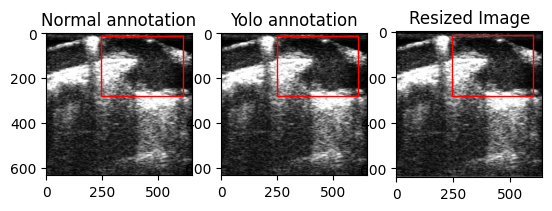

b124ea8c-e101-4a15-ab12-04e4a6280784_52


<Figure size 640x480 with 0 Axes>

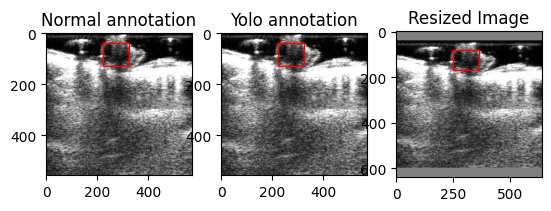

b4257959-88b7-447c-847a-bcaaf656b841_47


<Figure size 640x480 with 0 Axes>

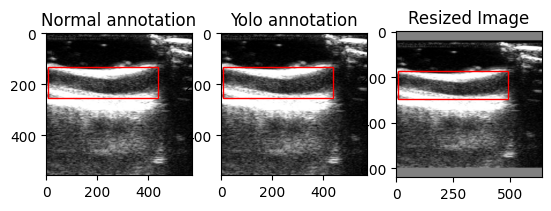

b4681d24-44f6-45d1-a407-09ac89b0b628_52


<Figure size 640x480 with 0 Axes>

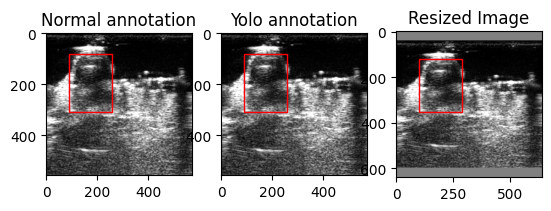

b5511598-3d05-4f3a-a4dc-b2cccbfc8bd9_47_aug


<Figure size 640x480 with 0 Axes>

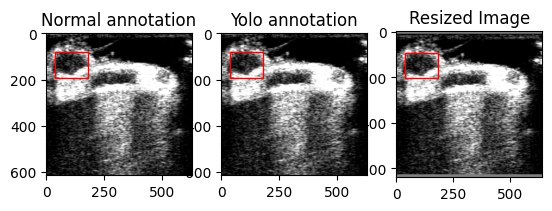

bf638677-f513-42c0-a100-a91ba941a4f4_76


<Figure size 640x480 with 0 Axes>

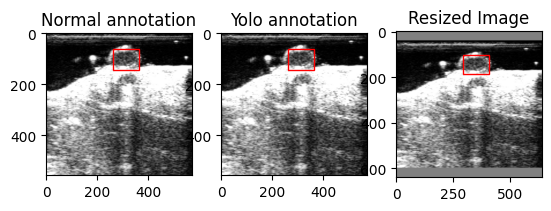

c654841c-a7a3-4aef-97dc-ac196f21c3cc_37_aug


<Figure size 640x480 with 0 Axes>

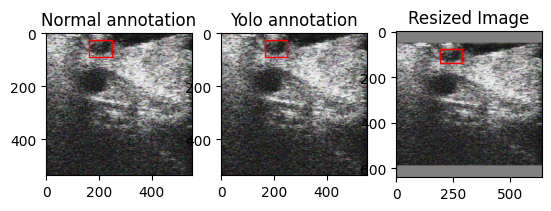

c8645400-45f0-4a6d-ad1d-c9f0c907d195_47


<Figure size 640x480 with 0 Axes>

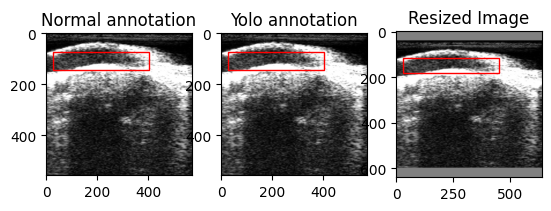

cc534e7d-e4f3-44e4-b48e-c10cd82c782f_77_aug


<Figure size 640x480 with 0 Axes>

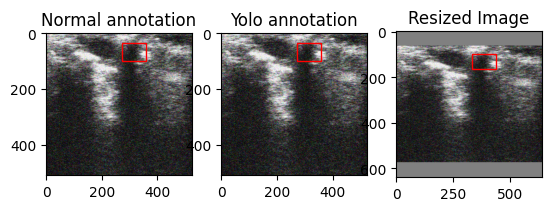

ccfa7f92-36b0-4c46-875e-e5158141a27f_14


<Figure size 640x480 with 0 Axes>

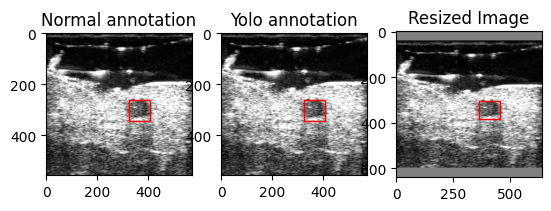

cf794470-34bb-4c56-b7e6-e450f5324b39_37


<Figure size 640x480 with 0 Axes>

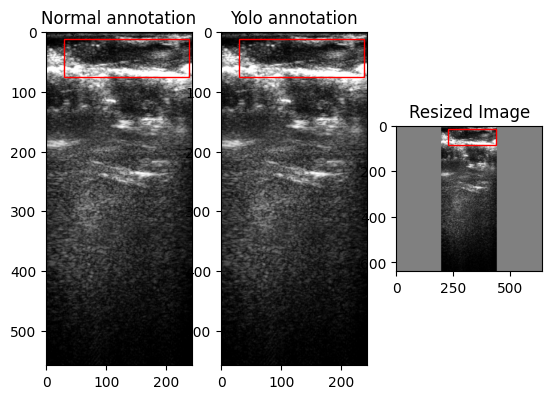

e796e7e1-8ed8-477d-83a0-f24f5fb14e4a_50_aug


<Figure size 640x480 with 0 Axes>

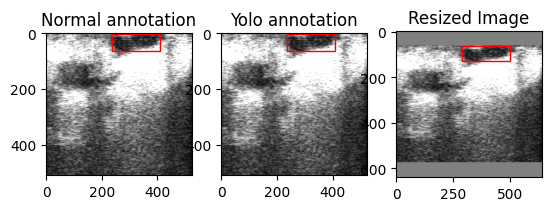

ee987619-f4f9-46e5-ac06-0414aacfbc9c_101


<Figure size 640x480 with 0 Axes>

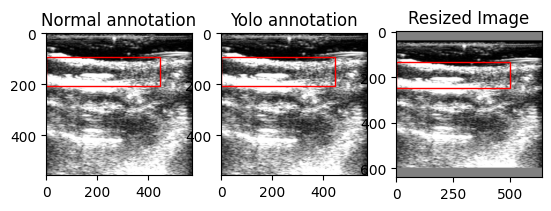

f6a04e17-c2b7-442a-986d-ce56250b87b4_32


<Figure size 640x480 with 0 Axes>

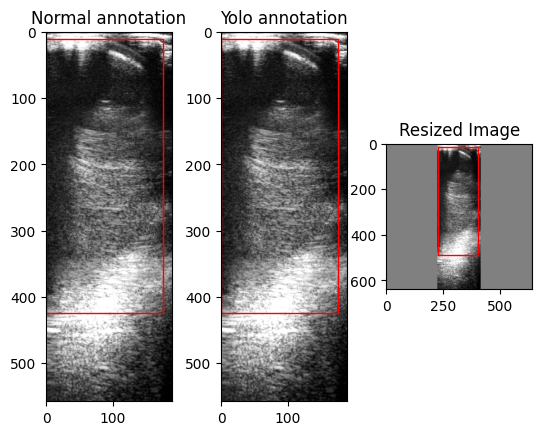

f7d0f6c8-e94a-4c8c-8a46-b4b63542811e_77_aug


<Figure size 640x480 with 0 Axes>

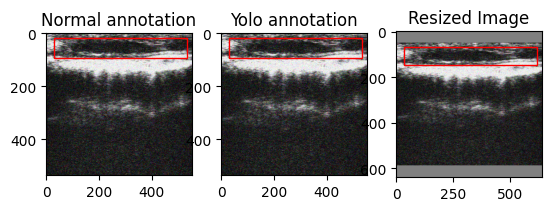

fb116090-b97f-4c12-a8b9-b5e52af40fd5_37


<Figure size 640x480 with 0 Axes>

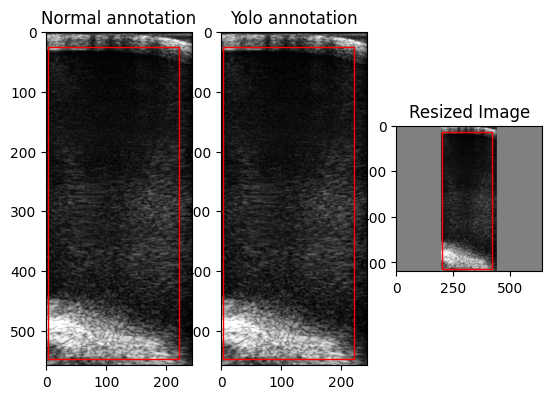

ff12dcb6-0dce-4e96-9c7e-84db4180a307_52_aug


<Figure size 640x480 with 0 Axes>

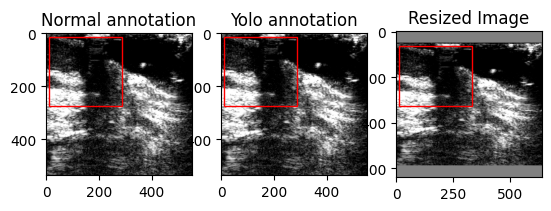

In [13]:
import collections

def side_by_side(X, y, img_object, path):
    #Plot 50 images side by side

    number = 0
    img_list = []
    df_new = pd.DataFrame(columns = ["number", "bb-box", "label", "label2"])

    plot_dict = {}
    for images, label in zip(X, y.values):
            if images in img_object:
                image_path = f"{path}/{images}.png" 
                if os.path.exists(image_path) == True:
                    number += 1
                    if number > 50:
                         break
                    else:
                        #For image
                        img_list.append(images)
                        df_new.loc[len(df_new.index)] = [label[0], label[1], label[2], label[3]]    #new dataframe for labels

                        plot_dict[images] = label
    od = collections.OrderedDict(sorted(plot_dict.items()))

    for i, (key, value) in enumerate(od.items()):
        
        image_path = f"{path}/{key}.png"    
        img = Image.open(image_path)
        print(key)
        height = img.height
        width = img.width
                        
        box_array = box_labels(value)
        x1, y1, x2, y2 = boundingboxes(box_array, width)
        border = find_border(x1, y1, x2, y2)

        x_center, y_center, box_width, box_height = boundingboxes_yolo(box_array, height, width)
        yolo_border = find_border_yolo(x_center, y_center, box_width, box_height, height, width)

        resized_image, x1_after, y1_after, x2_after, y2_after = resize_image(img, height, width, x1, y1, x2, y2)
        resized_border = find_border(x1_after, y1_after, x2_after, y2_after)
        if i == 7:
             print(yolo_border)
             print(resized_border)

        plot_bb_ss(img, resized_image, "Normal annotation", "Yolo annotation", border, yolo_border, resized_border)
        #plot_one(img, border)
    return img_list, df_new
    
path = "/Volumes/T7/Master/Data_augment/PNGImages"
img_list, y_df = side_by_side(X_train,y_train, img_object, path)